## 🔹 Введение
Этот скрипт предназначен для анализа и прогнозирования Lifetime Value (LTV) пользователей.
Используются логарифмическая регрессия и степенная аппроксимация для предсказания поведения клиентов со временем.

## 🔹 Что делает скрипт?
✅ Генерирует данные о платежах пользователей с экспоненциальным спадом 💸  
✅ Группирует и вычисляет ключевые метрики: ARPU, LTV 📊  
✅ Обучает модели прогнозирования:
   🔸 Логарифмическую полиномиальную регрессию  
   🔸 Степенную функцию для долгосрочного тренда  
✅ Визуализирует прогноз LTV с помощью интерактивных графиков

## 🔹 Где можно применить?
🔹 Анализ монетизации пользователей в играх 🎮  
🔹 Прогнозирование выручки в e-commerce 🛍  
🔹 Оценка окупаемости маркетинговых кампаний 📈 

In [122]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt


# Функция преобразования данных
# Группируем данные по количеству дней с момента регистрации, считаем сумму платежей и количество уникальных пользователей
# ARPU = Средний доход на одного пользователя (считаем как сумма платежей деленная на количество пользователей)
# LTV = Кумулятивный ARPU, показывающий, сколько в среднем приносит каждый пользователь со временем
# sigma = Стандартное отклонение (ошибка) для взвешенной регрессии

def transform_data(df: pd.DataFrame):    
    data_avg = df.groupby('days_since_reg').agg({'amount_in_usd': 'sum', 'user_id': 'nunique'}).reset_index()
    data_avg['ARPU'] = data_avg['amount_in_usd'] / data_avg['user_id']
    data_avg['LTV'] = data_avg['ARPU'].cumsum()
    data_avg['sigma'] = 1 / (data_avg['user_id']**0.5)  # Ошибка для взвешенной регрессии
    return data_avg

# Создание синтетического датасета

In [126]:
# Количество записей и уникальных пользователей
num_records = 5000  # Общее количество платежных записей
num_users = 1000  # Количество уникальных пользователей

# Генерация уникальных user_id (случайные числа в заданном диапазоне)
unique_user_ids = np.random.choice(range(10000, 9992299), num_users, replace=False)

# Случайные даты регистрации пользователей
user_reg_dates = {
    user_id: np.random.choice(pd.date_range(start="2023-06-01", end="2024-01-01"))
    for user_id in unique_user_ids
}

# Функция для генерации дней с момента регистрации с экспоненциальным спадом вероятности платежей

def generate_days_since_reg(num_payments):
    prob_decay = np.exp(-np.linspace(0, 20, 365))  # Экспоненциальный спад вероятности
    prob_decay /= prob_decay.sum()  # Нормализация вероятностей
    
    days = np.random.choice(np.arange(1, 366), size=num_payments, p=prob_decay)  # Выбор дней по распределению
    return np.sort(days)  # Сортировка дней по порядку

# Создание платежей
user_ids = []
payment_dates = []
days_since_reg_list = []

# Перебираем каждого пользователя и генерируем платежи
for user_id in unique_user_ids:
    reg_date = user_reg_dates[user_id]  # Дата регистрации
    num_payments = np.random.randint(1, 10)  # Количество платежей у пользователя (от 1 до 10)
    
    # Генерация дней с момента регистрации
    days_since_reg = generate_days_since_reg(num_payments)
    
    for day in days_since_reg:
        pay_date = reg_date + pd.Timedelta(days=day)  # Дата платежа
        if pay_date > pd.Timestamp("2024-12-31"):
            break  # Исключаем платежи, выходящие за 2024 год
        
        user_ids.append(user_id)
        payment_dates.append(pay_date)
        days_since_reg_list.append(day)

# Преобразование дат
reg_dates = [user_reg_dates[user_id] for user_id in user_ids]

# Генерация случайных платежных сумм от 1 до 4 USD
amounts = np.round(np.random.uniform(1, 4, size=len(user_ids)), 2)

# Создание финального DataFrame с платежными данными
df_payments = pd.DataFrame({
    "user_id": user_ids,
    "reg_date": reg_dates,
    "payment_date": payment_dates,
    "days_since_reg": days_since_reg_list,
    "amount_in_usd": amounts
})

# преобразование датасета

In [128]:
# Преобразование данных для анализа
data_avg = transform_data(df_payments)

# Проверка данных перед аппроксимацией
if data_avg['days_since_reg'].isna().sum() > 0 or data_avg['LTV'].isna().sum() > 0:
    print("Есть пропущенные значения в данных")
    data_avg = data_avg.dropna()

# Прогнозирование

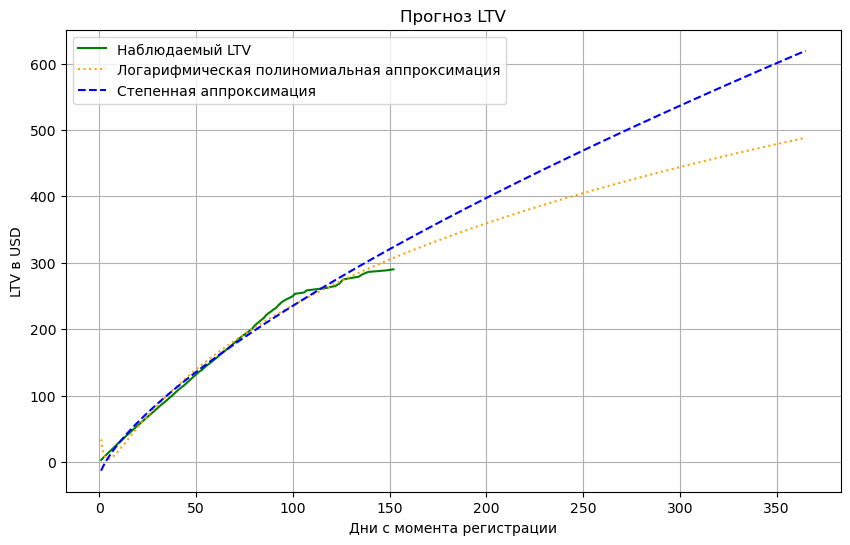

In [132]:
try:
    X = np.log1p(data_avg['days_since_reg']).values.reshape(-1, 1)
    poly = PolynomialFeatures(degree=2, include_bias=False)
    X_poly = poly.fit_transform(X)
    y = data_avg['LTV'].values
    
    model = LinearRegression()
    model.fit(X_poly, y)
    
    max_days = 365
    days = np.linspace(1, max_days, max_days)
    X_pred = np.log1p(days).reshape(-1, 1)
    X_pred_poly = poly.transform(X_pred)
    LTV_pred = model.predict(X_pred_poly)
    
    def power_func(x, a, b, c):
        return a * (x ** b) + c
    
    popt, _ = curve_fit(power_func, data_avg['days_since_reg'], data_avg['LTV'], maxfev=5000)
    LTV_power_pred = power_func(days, *popt)
    
    # Визуализация с Matplotlib и сохранение в файл
    plt.figure(figsize=(10, 6))
    plt.plot(data_avg['days_since_reg'], data_avg['LTV'], label='Наблюдаемый LTV', color='green')
    plt.plot(days, LTV_pred, label='Логарифмическая полиномиальная аппроксимация', linestyle='dotted', color='orange')
    plt.plot(days, LTV_power_pred, label='Степенная аппроксимация', linestyle='dashed', color='blue')
    
    plt.title('Прогноз LTV')
    plt.xlabel('Дни с момента регистрации')
    plt.ylabel('LTV в USD')
    plt.legend()
    plt.grid()
    plt.savefig('ltv_forecast.png')  # Сохранение графика в файл
    plt.show()
except Exception as e:
    print(f"Ошибка при аппроксимации: {e}")
